In [1]:
import gymnasium as gym
from tqdm.notebook import trange
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def create_policy_network(state_size, actions_no, hidden_size):
    return torch.nn.Sequential(
        torch.nn.Linear(state_size, hidden_size),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(hidden_size, actions_no),
        torch.nn.Softmax(dim=0)
    )

In [3]:
def create_policy_and_optimizer(game:gym.Env, hidden_size, learning_rate):
    assert len(game.observation_space.shape) == 1
    assert len(game.action_space.shape) == 1
    assert game.action_space.dtype == np.int
    state_size = game.observation_space.shape[0]
    actions_no = game.action_space.shape[0]
    model = create_policy_network(state_size, actions_no, hidden_size)
    model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, model_optimizer

In [4]:
def discount_rewards(rewards, discount_factor, normalize=True):
    ret = torch.pow(discount_factor, torch.arange(len(rewards)).float()) * rewards
    if normalize:
        return ret / torch.max(ret)
    else:
        return ret

In [5]:
def loss_fn(action_probs, disc_rewards):
    return -1 * torch.sum(disc_rewards * torch.log(action_probs))

In [6]:
def filter_timeseries(ts, p):
    tsf = np.nan * np.ones_like(ts)
    prev = ts[0]
    for i, v in enumerate(ts):
        tsf[i] = prev = p * prev + (1-p) * v
    return tsf

In [7]:
def compute_loss(loss_function, experience):
    states = torch.Tensor([state for (state, action, reward) in experience])
    # states = torch.Tensor(np.vstack([s for (s, a, r) in experience]))
    actions = torch.Tensor([action for (state, action, reward) in experience])
    # rewards = torch.Tensor([r for (s, a, r) in experience]).flip(dims=(0,))
    rewards = np.array([reward for (state, action, reward) in experience])
    rewards = [np.sum(rewards[i:]) for i in range(len(rewards))]
    rewards = torch.Tensor(rewards)
    # ----
    rewards_disc = discount_rewards(rewards, gamma)
    predictions = policy_network(states)
    probabilities = predictions.gather(dim=1, index=actions.long().view(-1, 1)).squeeze()
    return loss_function(probabilities, rewards_disc)

In [8]:
def choose_action(model, state):
    probabilities = model(torch.from_numpy(state).float())
    return np.random.choice(list(range(len(state))), p=probabilities.data.numpy())

In [9]:
def take_action(game, action):
    state, reward, terminated, truncated, _ = game.step(action)
    done = terminated or truncated
    return state, reward, done

In [10]:
env = gym.make("CartPole-v1")
policy_network, optimizer = create_policy_and_optimizer(env, hidden_size=150, learning_rate=0.01)

AssertionError: 

In [4]:
env.action_space.n

2

In [95]:
MAX_DURATION = 250
EPISODES = 500
gamma = 0.99

In [96]:
env = gym.make("CartPole-v1")
possible_actions = np.array([0, 1])
scores = []
for episode_ndx in trange(EPISODES):
    s, _ = env.reset()

    episode = []
    for t in range(MAX_DURATION):
        a = choose_action(policy_network, s)
        s_new, r, terminate = take_action(env, a)
        # episode.append((s, a, t + 1))
        episode.append((s, a, r))
        s = s_new
        if terminate:
            break

    scores.append(len(episode))
    loss = compute_loss(loss_fn, episode)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

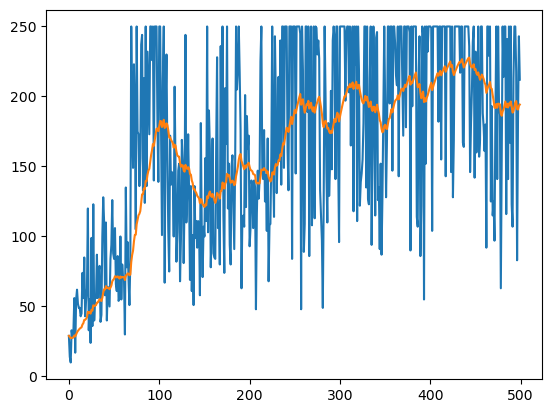

In [97]:
scores = np.array(scores)
filtered = filter_timeseries(scores, 0.95)
data = np.zeros((len(scores), 2))
data[:,0] = scores
data[:,1] = filtered
plt.plot(data)

In [19]:
env = gym.make("CartPole-v1", render_mode="human")
s, _ = env.reset()
for t in trange(MAX_DURATION):
    probs = policy_network(torch.from_numpy(s).float())
    a = torch.argmax(probs)
    # s_new, _, terminated, truncated, _ = env.step(a.item())
    s, _, done = take_action(env, a.item())
    if done:
        break


  0%|          | 0/250 [00:00<?, ?it/s]

In [20]:
env.close()